In [1]:
import pandas as pd
import numpy as np
import datarobot as dr
import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

In [2]:
# Connecting to DataRobot -------------------------------------------------

dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')

wine data shape: (4898, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5    

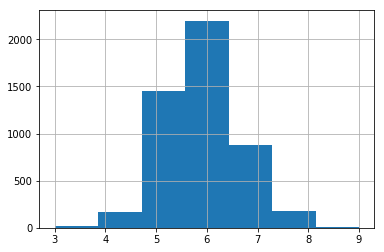

In [3]:
# Data preparation --------------------------------------------------------

wine = pd.read_csv('wine_data.csv', sep=';')

# Checks
print('wine data shape:', wine.shape)
print(wine.head())
wine['quality'].hist(bins=7)

w = wine.sample(frac=1, random_state=7)
div = int(w.shape[0]/3)

training = w[:div]
validation = w[div:(2*div)]
testing = w[(2*div):]

# Preparing data for user partitioning
training['partition'] = "train"
validation['partition'] = "valid"
model_data = pd.concat([training, validation])

In [4]:
# Start of Project --------------------------------------------------------

# Creating project in cloud
print('Creating project')
project = dr.Project.create(sourcedata=model_data, project_name='Wine Quality Prediction Intervals')

# Specifying custom partition
partition = dr.UserTVH(user_partition_col='partition',
                       training_level='train', validation_level='valid', holdout_level=None)

# Treating this as a regression type problem
print('Running autopilot in manual mode')
project.set_target(target='alcohol', worker_count=4,
                   mode=dr.AUTOPILOT_MODE.MANUAL,
                   partitioning_method=partition)  # If using a partition column

# Choosing three blueprints
bps = project.get_blueprints()
chosen_bps = []       
chosen_bps.append( next((bp for bp in bps if 'Light' in bp.model_type), None))
chosen_bps.append( next((bp for bp in bps if 'Ridge' in bp.model_type), None))
chosen_bps.append( next((bp for bp in bps if 'Support' in bp.model_type), None))

job_ids = []
models = []
for i in range(len(chosen_bps)):
    print('Training model:', chosen_bps[i].model_type)
    job_id = project.train(trainable=chosen_bps[i]) 
    job_ids.append(job_id)
    
for i in range(len(job_ids)):
    dr.models.modeljob.wait_for_async_model_creation(project.id, job_id, max_wait=6000)

Creating project
Running autopilot in manual mode
Training model: Light Gradient Boosted Trees Regressor with Early Stopping
Training model: Ridge Regression
Training model: Support Vector Regressor (Radial Kernel)


In [5]:
# Collect models - training is an async process, so you might have to run this cell a few times to output all 3 models
all_models = project.get_models()
for model in all_models:
    print('Model:',model.model_type)
    print('- blueprint id:',model.blueprint_id)
    print('- model id:',model.id)
    print('- sample_pct:',model.sample_pct)
    print('- featurelist_name:',model.featurelist_name)
    print('- RMSE validation metric:',model.metrics.get('RMSE')['validation'])
    print()

Model: Light Gradient Boosted Trees Regressor with Early Stopping
- blueprint id: 3c5cca4fb7b61d1a5a6170d0e145f2a0
- model id: 5b64b388566ad670389be99a
- sample_pct: 50.0
- featurelist_name: Informative Features
- RMSE validation metric: 0.35533

Model: Ridge Regression
- blueprint id: ac570c73959cf3e618d2ab0ae0554229
- model id: 5b64b38c566ad6711992d08a
- sample_pct: 50.0
- featurelist_name: Informative Features
- RMSE validation metric: 0.47697

Model: Support Vector Regressor (Radial Kernel)
- blueprint id: 489fd6a8ab404ee37a93b613b20eaa47
- model id: 5b64b390566ad66cd69862d7
- sample_pct: 50.0
- featurelist_name: Informative Features
- RMSE validation metric: 0.85368



In [6]:
# Making Prediction Intervals ---------------------------------------------

def get_training_predictions(project, model):
    '''
    Get training predictions for a given project and model

    Parameters:
    - project:  datarobot project
    - model:  datarobot model

    Returns:
    - datarobot training prediction object
    '''
    # Fetch any/all training predictions for a project
    all_training_predictions = dr.TrainingPredictions.list(project.id)

    # Get the model ids of all calculated training predictions
    model_train_preds = {}
    for training_predictions in all_training_predictions:
        model_train_preds[training_predictions.model_id] = training_predictions

    # If already done, extract. If not, go get them
    if model.id in model_train_preds.keys():
        training_predictions = model_train_preds.get(model.id)
    else:
        # Calculate new training predictions on holdout partition of dataset
        training_predictions_job = model.request_training_predictions(dr.enums.DATA_SUBSET.ALL)
        training_predictions = training_predictions_job.get_result_when_complete()

    return training_predictions


def get_new_predictions(project, model, prediction_data):
    '''
    Upload the scoring dataset and get the predictions

    Parameters:
    - project:  datarobot project
    - model:  datarobot model
    - prediction_data:  dataframe

    Returns:
    - dataframe
    '''
    datasets = project.get_datasets()

    if (len(datasets) == 0):
        pred_ds = project.upload_dataset(prediction_data)
    else:
        for ds in datasets:
            if ds.name == 'predict.csv':
                pred_ds = ds

    # Request predictions for the scoring dataset
    predict_job = model.request_predictions(pred_ds.id)

    # Get the predictions results when complete
    predictions = predict_job.get_result_when_complete()

    return predictions

# Adapted from the split conformal interval function in the conformalInference package
# Alpha is the miscoverage level (aka rejection region)
# So if you want 90% prediction intervals, set alpha = 0.1
def get_prediction_intervals(project, model, train_data, test_data,
                             alpha=0.1, locally_weighted=False):
    '''
    Generate prediction intervals and return as upper and lower bounds for each observation

    Parameters:
    - project:  datarobot project
    - model:  datarobot model
    - train_data:  dataframe of training data
    - test_data:  dataframe of testing data
    - alpha:  margin for prediction intervals
    - locally_weighted:  if false generate intervals from predictions - alpha, if true
                         train a eureqa model on the residuals and scale alpha to that

    Returns:
    - dataframe of predictions, true values, upper and lower prediction interval bounds
    '''
    # Set up data
    y = train_data[project.target].values
    
    # Check if training predictions have already been extracted
    training_predictions = get_training_predictions(project, model)
    df_train_pred = training_predictions.get_all_as_dataframe()
    fit = df_train_pred.prediction.values

    # Make predictions on new data
    prediction_data = test_data.drop(project.target, axis=1)  # Drop the target column
    predictions = get_new_predictions(project, model, prediction_data)

    # Add a column for the target labels (y_true)
    predictions['y_true'] = test_data[project.target].tolist()
    test_y_true = predictions['y_true'].values
    test_y_pred = predictions['prediction'].values
                
    # Get residuals
    res = np.absolute(y - fit)
    
    # If local weighting, need to train model to learn MAD residuals
    if locally_weighted:
        # Create a new target
        mad_train_data = train_data.copy()
        mad_train_data[project.target] = res
        project_mad = dr.Project.create(sourcedata=mad_train_data,
                                        project_name='MAD Model')
        # If user partition specified, use the same one
        if project.partition.get('user_partition_col'):
            mad_partition = dr.UserTVH(user_partition_col=project.partition.get('user_partition_col'),
                                       training_level=project.partition.get('training_level'),
                                       validation_level=project.partition.get('validation_level'),
                                       holdout_level=None)
            project_mad.set_target(target=project.target,
                                   mode=dr.AUTOPILOT_MODE.MANUAL,
                                   metric="MAE",
                                   partitioning_method=mad_partition)  # If using a partition column
        else:
            project_mad.set_target(target=project.target,
                                   mode=dr.AUTOPILOT_MODE.MANUAL,
                                   metric="MAE")
        # Find a Eureqa model
        bps = project_mad.get_blueprints()
        ebp = next(bp for bp in bps if 'Eureqa Generalized Additive Model' in bp.model_type)

        # In case a model was built not on the informative features
        flists = project.get_featurelists()
        fl = next((flist for flist in flists if flist.id == model.featurelist_id), None)
        new_list = project_mad.create_featurelist('new feature list', fl.features)        
        
        # Train on all data
        project_mad.unlock_holdout()
        mad_model_job_id = project_mad.train(trainable=ebp.id, featurelist_id=new_list.id, sample_pct=100)
        mad_model = dr.models.modeljob.wait_for_async_model_creation(project_mad.id, mad_model_job_id, max_wait=6000)
        mad_out = get_training_predictions(project_mad, mad_model)
        mad_out_df = mad_out.get_all_as_dataframe()
        mad_out = mad_out_df.prediction.values
        mad_pred_df = get_new_predictions(project_mad, mad_model, prediction_data)
        mad_pred = mad_pred_df.prediction.values
        
        # Don't need project anymore
        project_mad.delete()

        # Scale predictions by predicted MAD deviations on training
        res = res / mad_out
    else:
        mad_out = np.ones(res.shape[0]) 
        mad_pred = np.ones(test_data.shape[0])

    # Taking the (1 - alpha) percentile for desired coverage
    d = np.percentile(res, (100 - (alpha*100)))
    
    # Training coverage
    coverage = np.logical_and(y >= (fit - d * mad_out), y <= (fit + d * mad_out)).sum() / train_data.shape[0]

    # Create bounds
    lower = test_y_pred - d * mad_pred
    upper = test_y_pred + d * mad_pred

    # Row ID
    rowID = np.arange(0, test_data.shape[0])

    # Format result as a dataframe, 
    # including adding the y_true target back in for graphing purposes
    out = df_p = pd.DataFrame({'rowID': rowID,
                               'predictions': test_y_pred, 'y_true': test_y_true,
                               'lower_bound': lower, 'upper_bound': upper})

    return out

print('Getting prediction intervals for model 1')
model_1 = get_prediction_intervals(project=project, model=all_models[0], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=False)
print('Getting prediction intervals for model 2')
model_2 = get_prediction_intervals(project=project, model=all_models[1], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=False)
print('Getting prediction intervals for model 3')
model_3 = get_prediction_intervals(project=project, model=all_models[2], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=False)
print('Done.')

Getting prediction intervals for model 1
Getting prediction intervals for model 2
Getting prediction intervals for model 3
Done.


model 1 coverage: 0.9179926560587516
model 2 coverage: 0.908812729498164
model 3 coverage: 0.9063647490820074


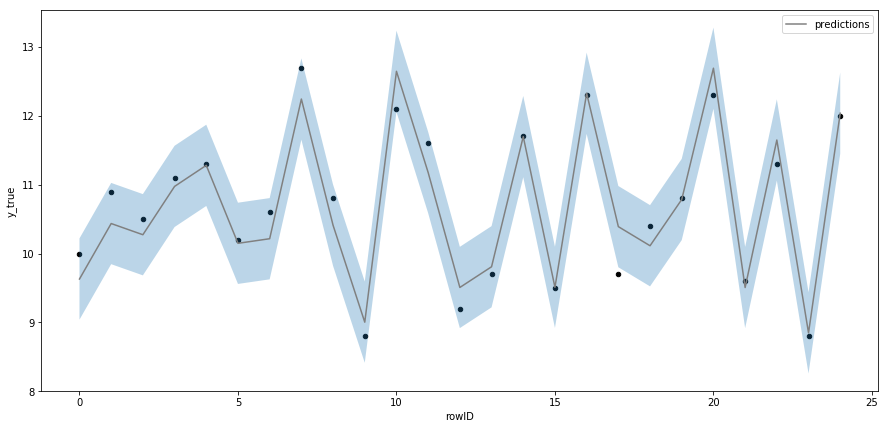

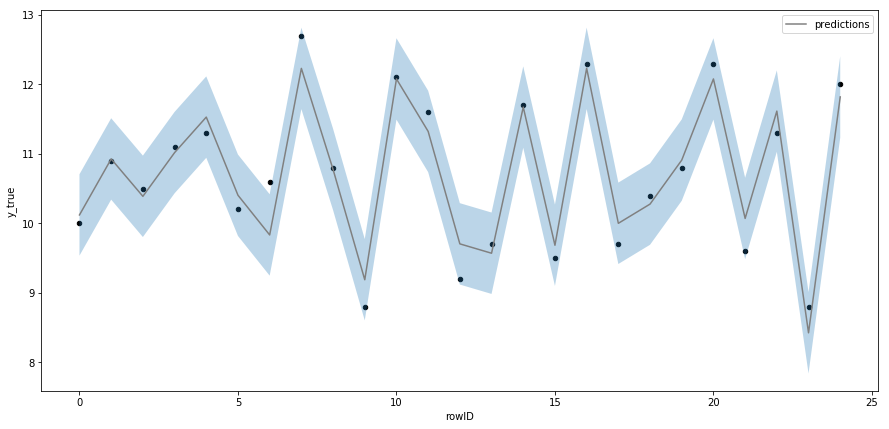

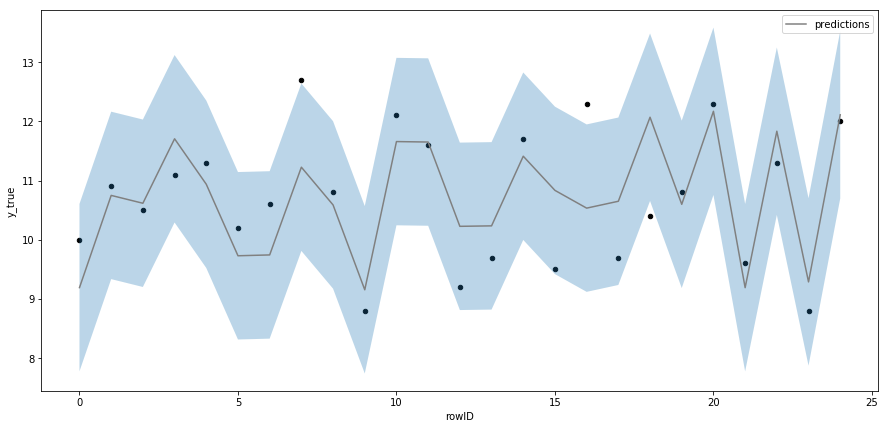

In [7]:
# Plotting Results --------------------------------------------------------

# Number of points to show
n = 25

subset = model_1[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

subset = model_2[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

subset = model_3[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

# Coverage on testing
print('model 1 coverage:',model_1[(model_1.y_true >= model_1.lower_bound) &
                                  (model_1.y_true <= model_1.upper_bound)].shape[0] / testing.shape[0]*1.)
print('model 2 coverage:',model_2[(model_2.y_true >= model_2.lower_bound) &
                                  (model_2.y_true <= model_2.upper_bound)].shape[0] / testing.shape[0]*1.)
print('model 3 coverage:',model_3[(model_3.y_true >= model_3.lower_bound) &
                                  (model_3.y_true <= model_3.upper_bound)].shape[0] / testing.shape[0]*1.)

In [8]:
# Locally-weighted prediction intervals -----------------------------------

print('Getting locally weighted prediction intervals for model 1')
model_1_lw = get_prediction_intervals(project=project, model=all_models[0], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=True)
print('Getting locally weighted prediction intervals for model 2')
model_2_lw = get_prediction_intervals(project=project, model=all_models[1], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=True)
print('Getting locally weighted prediction intervals for model 3')
model_3_lw = get_prediction_intervals(project=project, model=all_models[2], 
                                   train_data=model_data, test_data=testing, 
                                   alpha=0.1, locally_weighted=True)
print('Done.')

Getting locally weighted prediction intervals for model 1
Getting locally weighted prediction intervals for model 2
Getting locally weighted prediction intervals for model 3
Done.


model 1 coverage: 0.9045287637698899
model 2 coverage: 0.9094247246022031
model 3 coverage: 0.8892288861689106


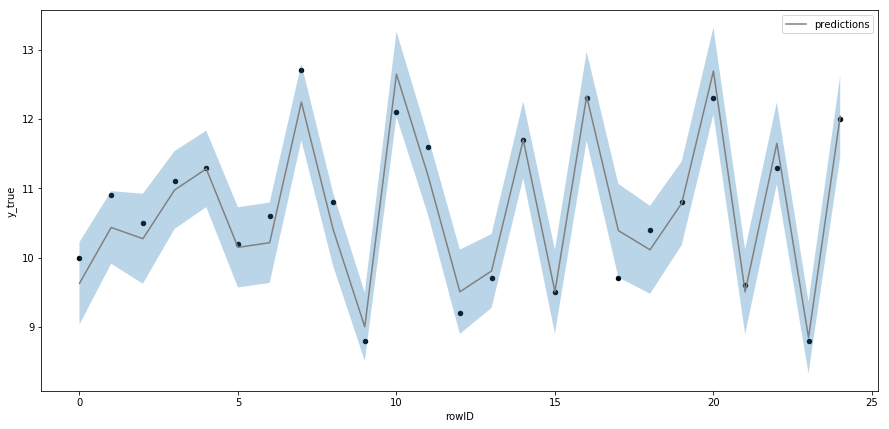

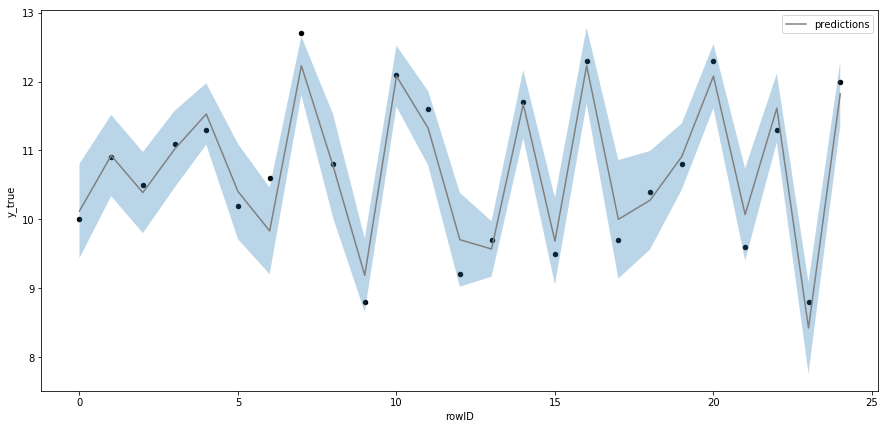

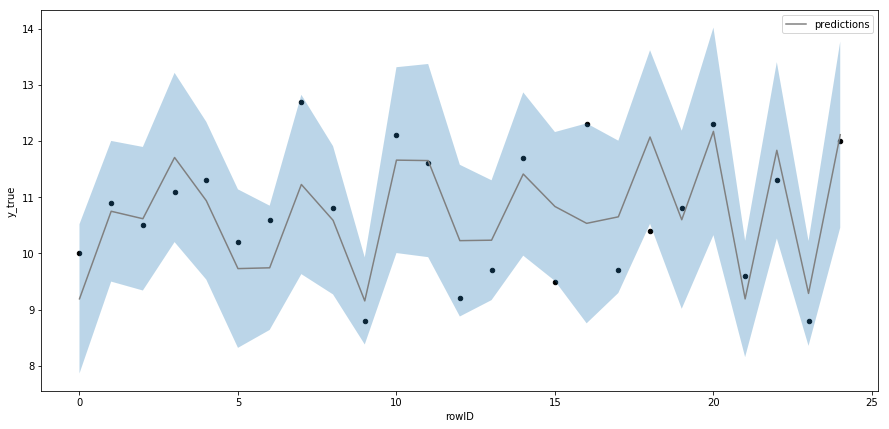

In [9]:
# Number of points to show
n = 25

subset = model_1_lw[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

subset = model_2_lw[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

subset = model_3_lw[:n]    
fig, ax = plt.subplots(1,1,figsize=(15,7))
subset.plot(kind='scatter',x='rowID',y='y_true', color='black', ax=ax)
subset.plot(x='rowID',y='predictions', color='grey', ax=ax)
plt.fill_between(subset.rowID, subset.lower_bound, subset.upper_bound,alpha=.3)

# Coverage on testing
print('model 1 coverage:',model_1_lw[(model_1_lw.y_true >= model_1_lw.lower_bound) &
                                     (model_1_lw.y_true <= model_1_lw.upper_bound)].shape[0] / testing.shape[0]*1.)
print('model 2 coverage:',model_2_lw[(model_2_lw.y_true >= model_2_lw.lower_bound) &
                                     (model_2_lw.y_true <= model_2_lw.upper_bound)].shape[0] / testing.shape[0]*1.)
print('model 3 coverage:',model_3_lw[(model_3_lw.y_true >= model_3_lw.lower_bound) &
                                     (model_3_lw.y_true <= model_3_lw.upper_bound)].shape[0] / testing.shape[0]*1.)